<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/Fundus-eye-disease-detection/Resnet3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Test Accuracy: 0.9079102715466352
Classification Report:
                      precision    recall  f1-score   support

diabetic_retinopathy       0.99      0.99      0.99       221
              normal       0.88      0.88      0.88       215
            glaucoma       0.83      0.84      0.83       203
            cataract       0.94      0.91      0.92       208

            accuracy                           0.91       847
           macro avg       0.91      0.91      0.91       847
        weighted avg       0.91      0.91      0.91       847



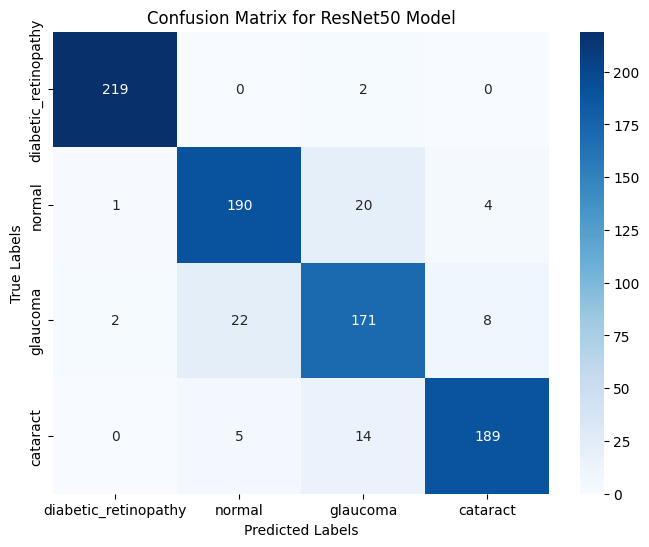

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


def get_class_directories(base_directory):
    return {folder_name: os.path.join(base_directory, folder_name) for folder_name in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, folder_name))}

def load_model(input_shape=(224, 224, 3), trainability=False):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    preprocessor = tf.keras.applications.resnet50.preprocess_input
    for layer in base_model.layers:
        layer.trainable = trainability
    model = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)
    return model, preprocessor

def preprocess_and_extract_features(img_path, model, preprocess_input, img_size=(224, 224)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array, verbose=0)
    return features.flatten()

def extract_and_save_features(image_files, model, preprocess_input, output_dir, category):
    features_list = [preprocess_and_extract_features(img, model, preprocess_input) for img in image_files]
    os.makedirs(output_dir, exist_ok=True)
    np.save(f'{output_dir}/{category}_features.npy', np.array(features_list))

def get_class_weight_dict(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    return dict(zip(np.unique(y_train), class_weights))

# Define dataset paths
DATA_DIR = '/content/drive/MyDrive/data set/dataset'
base_data_directory = DATA_DIR
feature_directory = '/content/drive/MyDrive/extracted_feature'

# Get image directories
image_directories = get_class_directories(base_data_directory)
class_names = list(image_directories.keys())

# Split dataset
train_dirs, test_dirs = {}, {}
for category, dir_path in image_directories.items():
    img_files = os.listdir(dir_path)
    train_files, test_files = train_test_split(img_files, test_size=0.2, random_state=42)
    train_dirs[category] = [os.path.join(dir_path, f) for f in train_files]
    test_dirs[category] = [os.path.join(dir_path, f) for f in test_files]

# Load ResNet50 model
model, preprocess_input = load_model()

# Extract and save features
for split_name, dirs in zip(['train', 'test'], [train_dirs, test_dirs]):
    for category, image_files in dirs.items():
        output_dir = f'{feature_directory}/ResNet50/{split_name}'
        extract_and_save_features(image_files, model, preprocess_input, output_dir, category)

# Load features
X_train, y_train, X_test, y_test = [], [], [], []
for category in class_names:
    train_features = np.load(f'{feature_directory}/ResNet50/train/{category}_features.npy')
    test_features = np.load(f'{feature_directory}/ResNet50/test/{category}_features.npy')
    X_train.append(train_features)
    y_train.append(np.full(train_features.shape[0], class_names.index(category)))
    X_test.append(test_features)
    y_test.append(np.full(test_features.shape[0], class_names.index(category)))

X_train, y_train = np.concatenate(X_train, axis=0), np.concatenate(y_train, axis=0)
X_test, y_test = np.concatenate(X_test, axis=0), np.concatenate(y_test, axis=0)

# Train and evaluate SGDClassifier
class_weight_dict = get_class_weight_dict(y_train)
sgd_clf = SGDClassifier(loss='log_loss', class_weight=class_weight_dict, max_iter=1000, learning_rate='adaptive', eta0=0.01, random_state=42)
sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)

# Print results
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for ResNet50 Model")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
